In [1]:
import deconV.deconV as dv

import glob, tqdm, time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
params = {
    "jupyter": True,
    "tqdm": True,
    "cell_type_key": "cellType",
    "layer": "counts",
    "index_col": 0,
    "selected_ct": ["0", "1", "2"],
    "model_type": "poisson",
    "ignore_others": True,
    "n_top_genes": -1,
    "plot_pseudo_bulk": False,
    "lr": 0.01,
    "epochs": 5000,
    "fig_fmt": "png",
    "indir": "../../data/synthetic100/",
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [3]:
sadata = dv.read_data(os.path.join("../../data/GSE136148/", "sc.tsv"))
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [4]:
print("Reading bulk data...")
badata = dv.read_data(os.path.join(params["indir"], "bulk.csv"), is_bulk=True, transpose_bulk=True)
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 100, genes: 8425


In [5]:
print("Reading pheno data...")
pheno_df = pd.read_csv(os.path.join("../../data/GSE136148/", "pdata.tsv"), sep="\t", index_col=params["index_col"])
pheno_df.index.name = None

sadata.obs = pd.concat([sadata.obs, pheno_df], axis=1)
assert params["cell_type_key"] in sadata.obs.columns, f"{params['cell_type_key']} not in obs columns"
sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype(str)
sadata.obs.groupby(params["cell_type_key"]).size()

Reading pheno data...


cellType
0    1988
1     686
2     319
3      29
dtype: int64

In [6]:
print("Preprocessing data...")
sadata, badata = dv.preprocess(sadata, badata, params)
print("After preprocessing:")
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")
print(f"bulk RNA-seq data - samples: {badata.shape[0]}, genes: {badata.shape[1]}")

assert sadata.shape[1] == badata.shape[1], "scRNA-seq and bulk RNA-seq data have different number of genes"

Preprocessing data...
After preprocessing:
scRNA-seq data - cells: 2993, genes: 8424
bulk RNA-seq data - samples: 100, genes: 8424


In [7]:
sadata.obs["cellType"] = sadata.obs["cellType"].astype("category")
cell_types = sadata.obs[params["cell_type_key"]].cat.categories.tolist()
cell_types

['0', '1', '2']

In [8]:
decon = dv.DeconV(sadata, badata, cell_types, params, use_sub_types=False)

/home/lutrarutra/Documents/dev/fimm/deconv/deconV/deconV.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.sadata.var[f"bulk_residual_{i}"] = self.sadata.var[
/home/lutrarutra/Documents/dev/fimm/deconv/deconV/deconV.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.sadata.var[f"log_bulk_residual_{i}"] = self.badata.X[i, :] - np.log1p(
/home/lutrarutra/Documents/dev/fimm/deconv/deconV/deconV.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


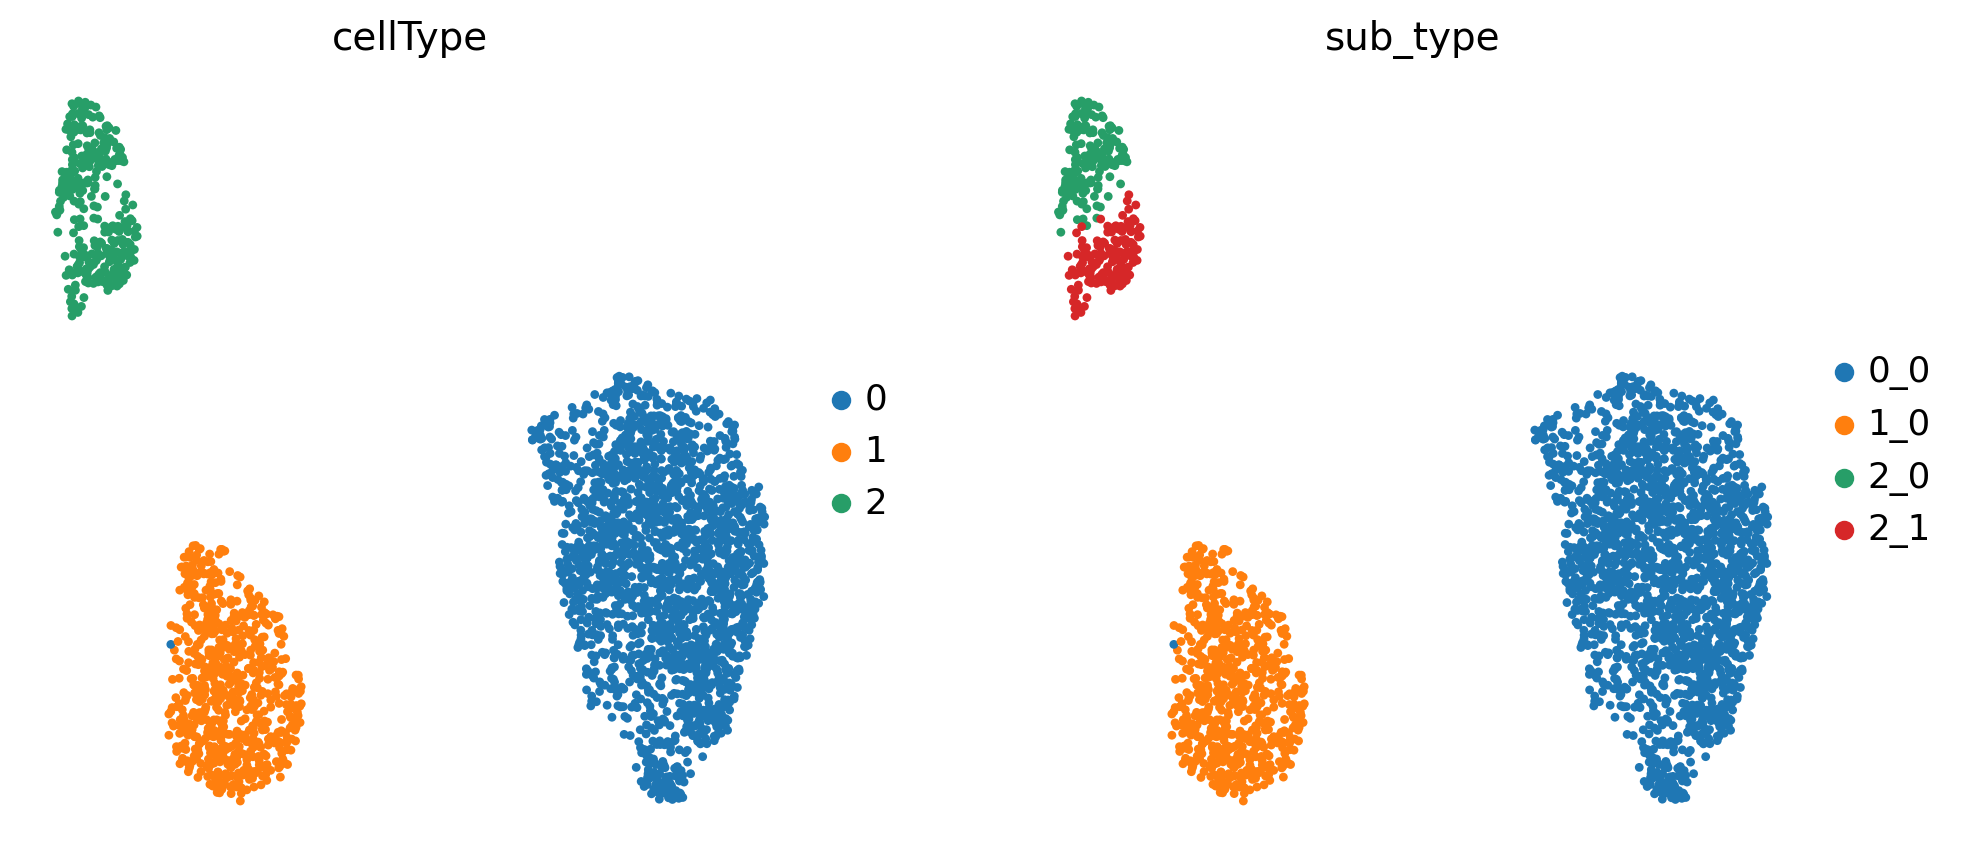

In [9]:
decon.sub_cluster(leiden_res=0.1)
dv.pl.umap_plot(decon, show=True, keys=[params['cell_type_key'], "sub_type"])

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/trimap/trimap_.py:747: UserWarning: 'weight_adj' is deprecated and will not be applied. Adjust 'weight_temp' if needed.
  warnings.warn(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


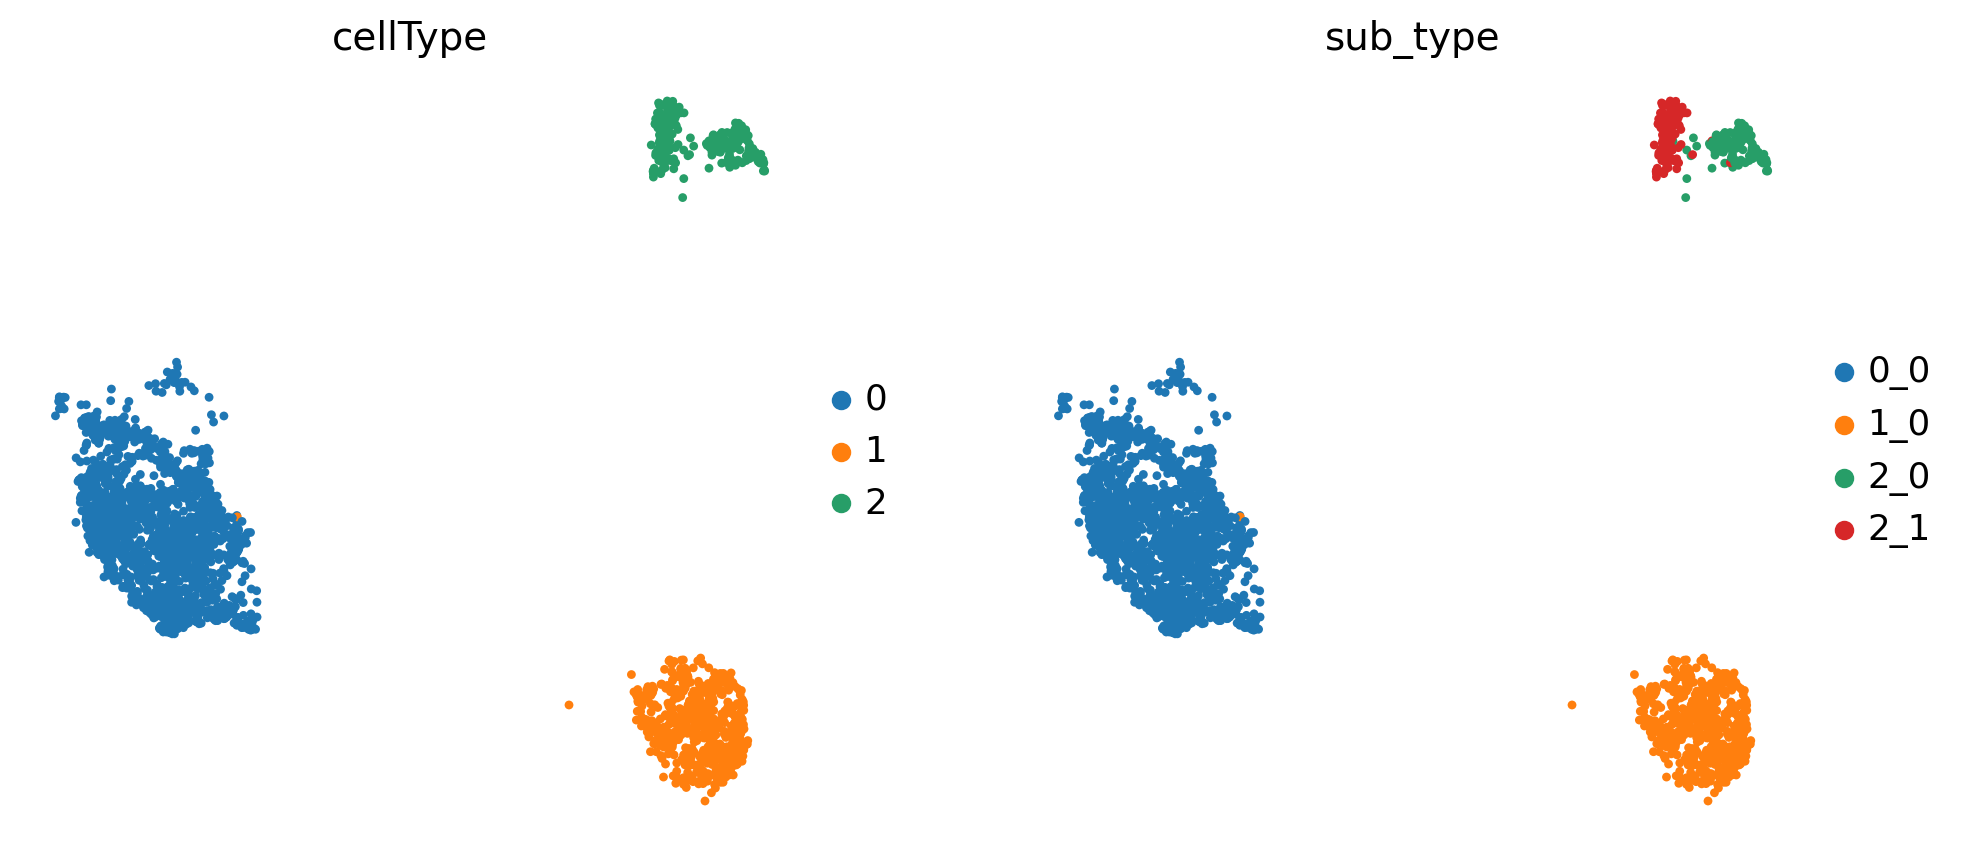

In [10]:
sc.external.tl.trimap(decon.sadata)
sc.external.pl.trimap(decon.sadata, color=[params["cell_type_key"], "sub_type"], ncols=2, frameon=False)

In [11]:
scout.tl.rank_marker_genes(decon.sadata, groupby=decon.label_key)

Added results to: adata.uns['de']['cellType']


In [12]:
top_variable_genes = []
for i, cell_type in enumerate(sadata.uns["de"][decon.label_key].keys()):
    top_variable_genes.extend(sadata.uns["de"][decon.label_key][cell_type].sort_values("gene_score").index[:10].tolist())

top_variable_genes = list(set(top_variable_genes))

In [13]:
# scout.ply.heatmap(
#     decon.sadata, top_variable_genes, categoricals=[decon.label_key], layout=dict(width=1200),
# )

In [14]:
# dv.pl.clustermap(decon.sadata, clusterby="cellType", categorical_features=[decon.label_key, "sub_type"], min_cells=45)

In [15]:
# decon.filter_outliers(dropout_mu_lim=2.5, dropout_lim=1.0, marker_zscore_lim=0.3, dispersion_lims=(-3, 1), pseudobulk_lims=(-8,8))
decon.filter_outliers()

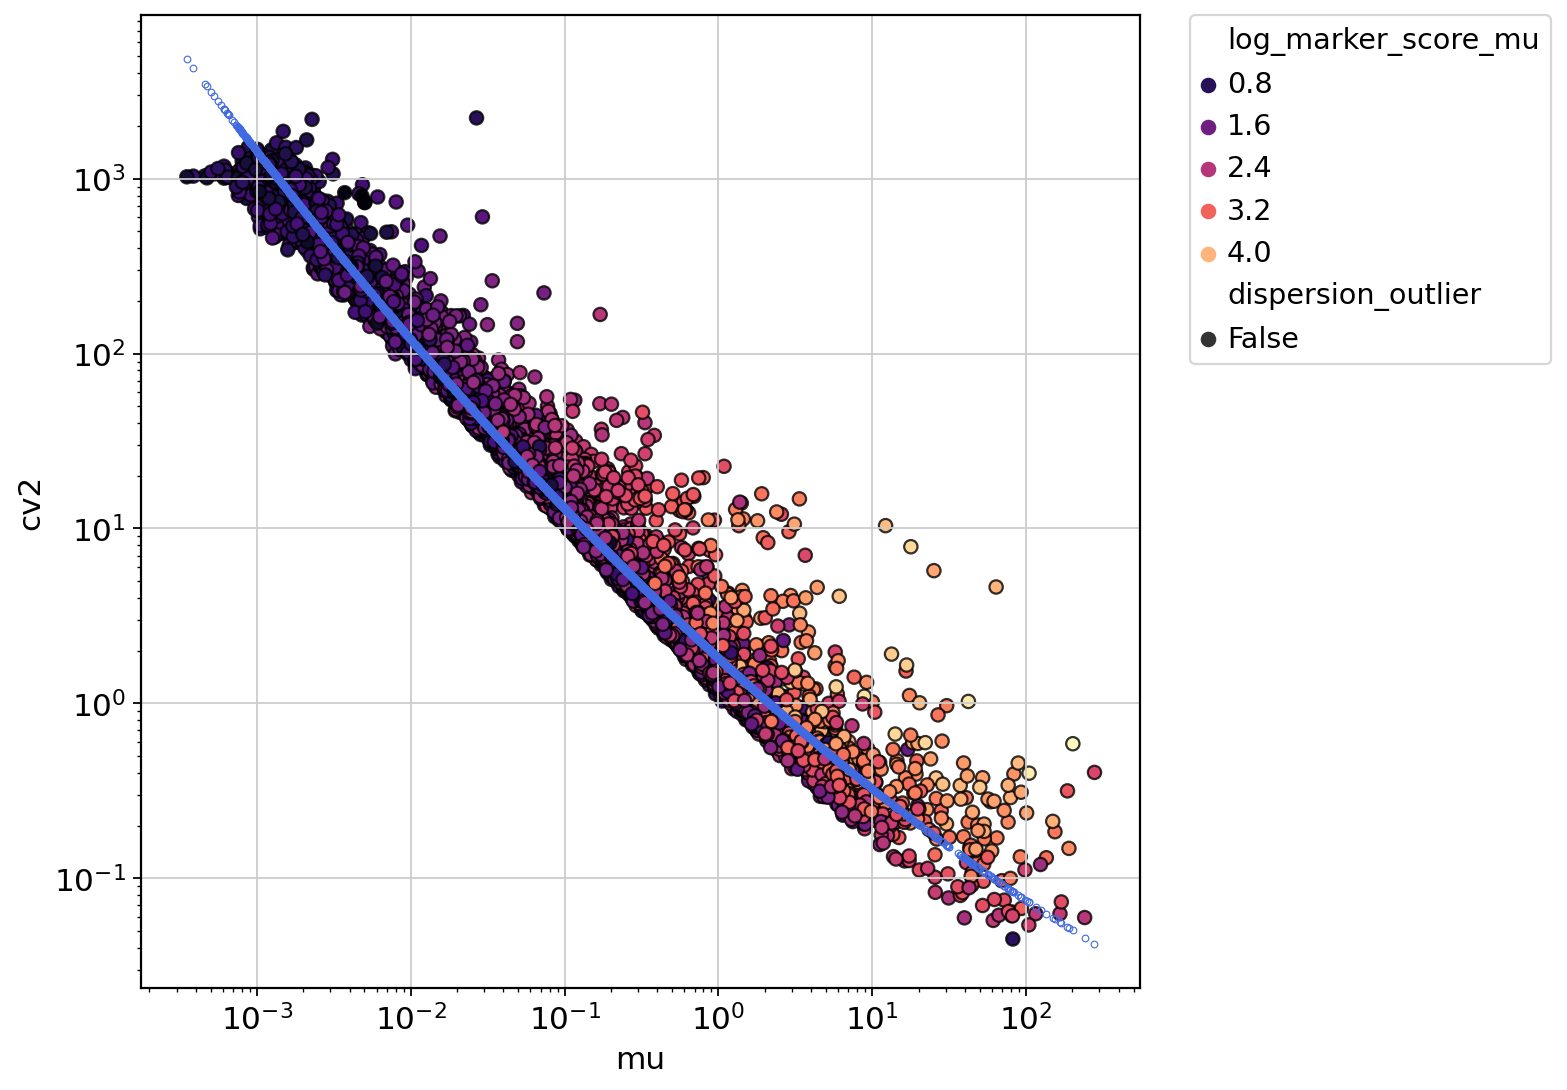

In [16]:
dv.pl.dispersion_plot(decon, hue="log_marker_score_mu", style="dispersion_outlier", figsize=(8,8), dpi=80, separate_ct=False, palette="magma")

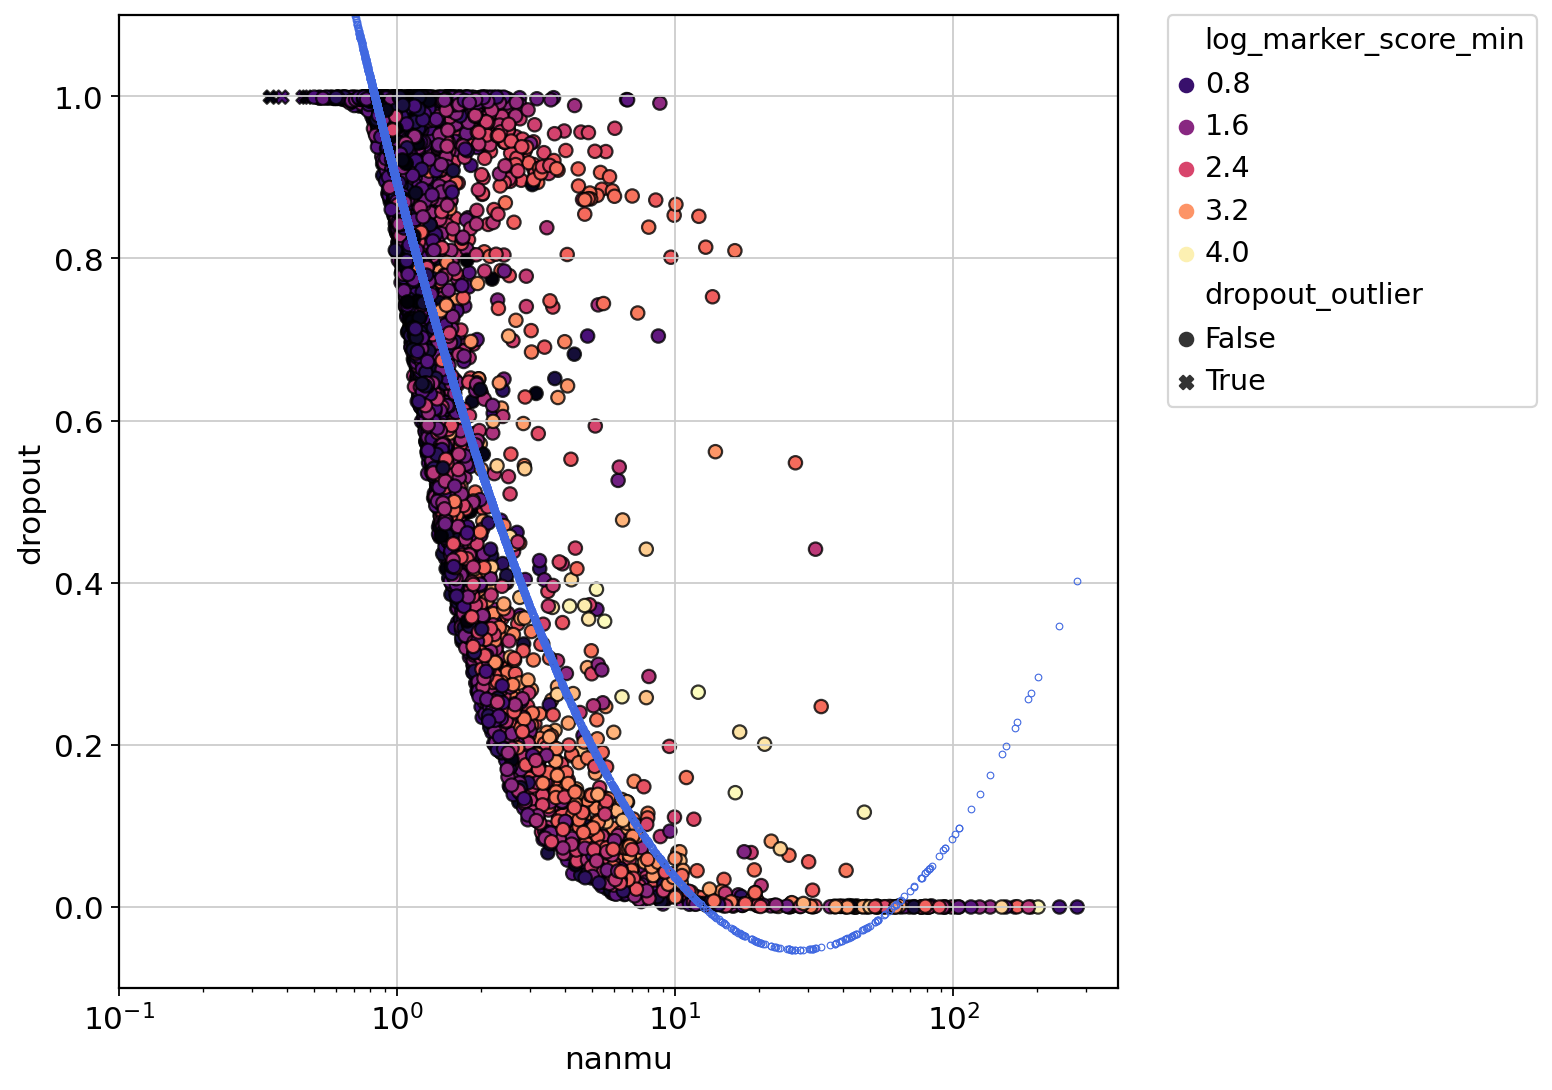

In [17]:
dv.pl.dropout_plot(decon, hue="log_marker_score_min", style="dropout_outlier", xlim=(0.1, None), dpi=80, separate_ct=False, palette="magma")

In [18]:
# pl.pseudo_bulk_plot(
#     decon, hue="log_bulk_residual", style="pseudobulk_outlier", palette="magma"
# )

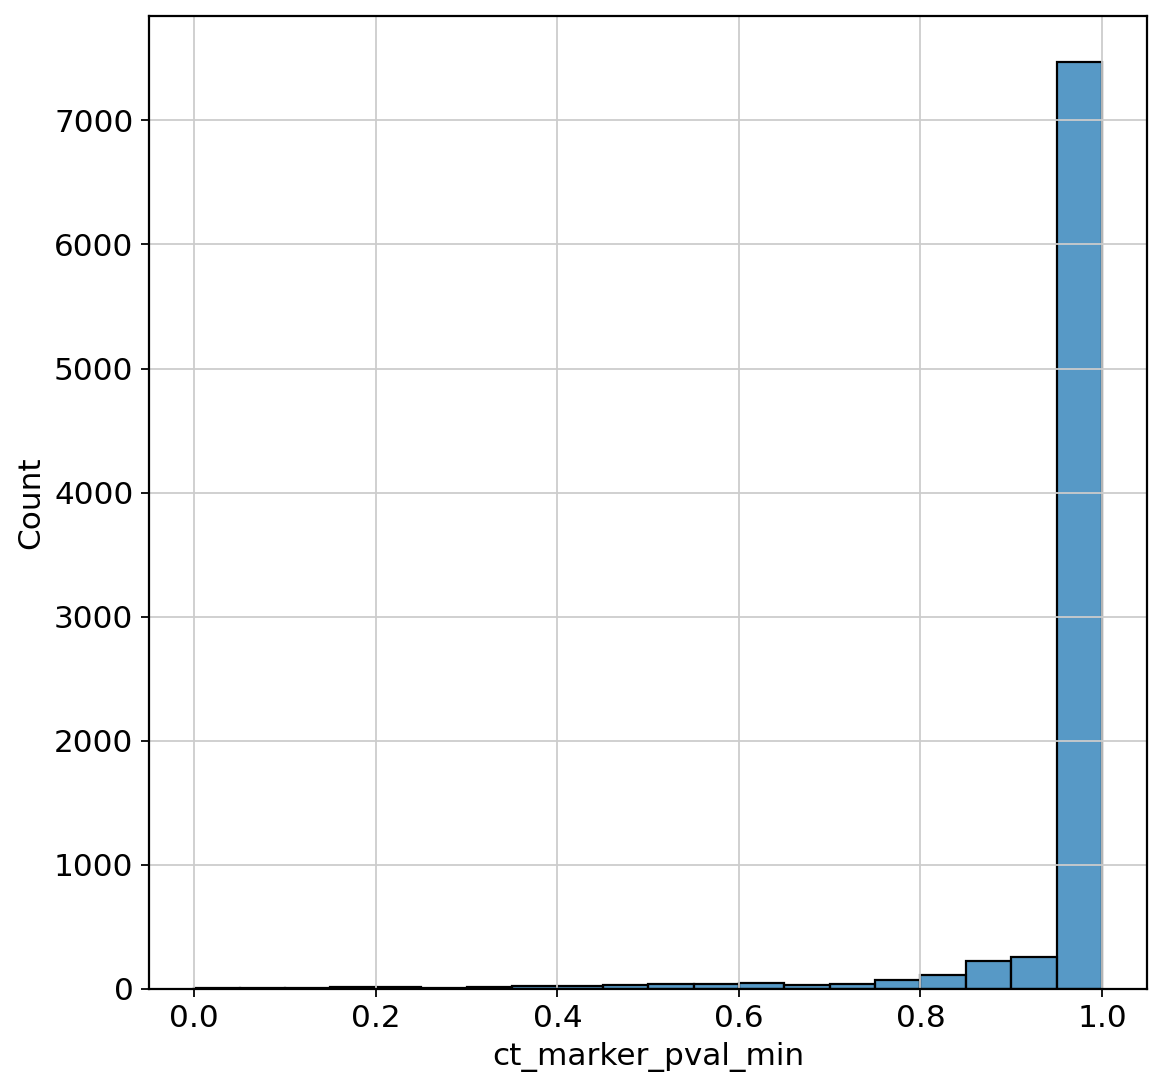

Creating signature for cell types: ['0', '1', '2']...


/home/lutrarutra/Documents/dev/fimm/deconv/deconV/deconV.py:395: RuntimeWarning: divide by zero encountered in divide
  self.sadata.layers["counts"].sum(0) / self.badata.layers["counts"],


In [19]:
# decon.init_dataset(use_outliers=False, gene_weight_key="ct_marker_pval_max")
decon.init_dataset(use_outliers=False, gene_weight_key="ct_marker_pval_min")
decon.init_signature()

In [20]:
decon.gene_weights

tensor([1.0000, 0.5066, 0.9769,  ..., 0.9886, 0.7594, 1.0000],
       dtype=torch.float64)

Sample: 0/100


100%|██████████| 5000/5000 [00:04<00:00, 1191.87it/s, loss=1302801.5, p=0.53 0.15 0.32, lib_size=2613366.8] 


Sample: 1/100


100%|██████████| 5000/5000 [00:03<00:00, 1265.07it/s, loss=1204876.2, p=0.32 0.52 0.16, lib_size=1972993.2] 


Sample: 2/100


100%|██████████| 5000/5000 [00:04<00:00, 1163.14it/s, loss=2281352.0, p=0.32 0.20 0.48, lib_size=3705465.5]  


Sample: 3/100


100%|██████████| 5000/5000 [00:04<00:00, 1099.42it/s, loss=1020748.5, p=0.29 0.17 0.54, lib_size=2405982.0] 


Sample: 4/100


100%|██████████| 5000/5000 [00:04<00:00, 1121.91it/s, loss=3877432.1, p=0.22 0.45 0.33, lib_size=4071876.0]  


Sample: 5/100


100%|██████████| 5000/5000 [00:04<00:00, 1134.28it/s, loss=1054285.7, p=0.34 0.46 0.20, lib_size=2236130.8] 


Sample: 6/100


100%|██████████| 5000/5000 [00:04<00:00, 1113.15it/s, loss=5262446.2, p=0.46 0.23 0.31, lib_size=4837304.0]  


Sample: 7/100


100%|██████████| 5000/5000 [00:04<00:00, 1131.38it/s, loss=189641.4, p=0.18 0.02 0.80, lib_size=1447175.5] 


Sample: 8/100


100%|██████████| 5000/5000 [00:04<00:00, 1118.97it/s, loss=283972.8, p=0.38 0.57 0.05, lib_size=1001857.4] 


Sample: 9/100


100%|██████████| 5000/5000 [00:04<00:00, 1166.20it/s, loss=319457.4, p=0.46 0.46 0.08, lib_size=1195100.8]  


Sample: 10/100


100%|██████████| 5000/5000 [00:04<00:00, 1188.75it/s, loss=389440.8, p=0.45 0.34 0.21, lib_size=1321053.6]  


Sample: 11/100


100%|██████████| 5000/5000 [00:04<00:00, 1164.06it/s, loss=7524771.9, p=0.43 0.49 0.08, lib_size=4877769.5]  


Sample: 12/100


100%|██████████| 5000/5000 [00:04<00:00, 1180.70it/s, loss=545671.1, p=0.40 0.11 0.50, lib_size=1613069.2]  


Sample: 13/100


100%|██████████| 5000/5000 [00:04<00:00, 1169.29it/s, loss=129576.7, p=0.13 0.58 0.29, lib_size=776611.2]  


Sample: 14/100


100%|██████████| 5000/5000 [00:04<00:00, 1194.99it/s, loss=3662079.5, p=0.49 0.21 0.30, lib_size=4230517.0]  


Sample: 15/100


100%|██████████| 5000/5000 [00:04<00:00, 1196.91it/s, loss=3263431.5, p=0.40 0.28 0.32, lib_size=3640514.0]  


Sample: 16/100


100%|██████████| 5000/5000 [00:04<00:00, 1193.58it/s, loss=1163971.1, p=0.18 0.31 0.50, lib_size=2482565.0] 


Sample: 17/100


100%|██████████| 5000/5000 [00:04<00:00, 1128.39it/s, loss=1554438.0, p=0.57 0.26 0.17, lib_size=2417025.8] 


Sample: 18/100


100%|██████████| 5000/5000 [00:04<00:00, 1131.21it/s, loss=3786063.2, p=0.46 0.28 0.26, lib_size=3987480.8]  


Sample: 19/100


100%|██████████| 5000/5000 [00:04<00:00, 1133.15it/s, loss=310194.9, p=0.13 0.26 0.61, lib_size=1396067.8] 


Sample: 20/100


100%|██████████| 5000/5000 [00:04<00:00, 1119.70it/s, loss=2133645.5, p=0.38 0.36 0.26, lib_size=3015268.0]  


Sample: 21/100


100%|██████████| 5000/5000 [00:04<00:00, 1131.16it/s, loss=882583.1, p=0.17 0.31 0.52, lib_size=2171610.5]  


Sample: 22/100


100%|██████████| 5000/5000 [00:04<00:00, 1152.20it/s, loss=267924.3, p=0.06 0.10 0.84, lib_size=1355902.9] 


Sample: 23/100


100%|██████████| 5000/5000 [00:04<00:00, 1133.25it/s, loss=3272470.9, p=0.16 0.59 0.25, lib_size=3660320.0]  


Sample: 24/100


100%|██████████| 5000/5000 [00:04<00:00, 1184.97it/s, loss=7312210.9, p=0.13 0.80 0.07, lib_size=4943984.0]  


Sample: 25/100


100%|██████████| 5000/5000 [00:04<00:00, 1155.46it/s, loss=222842.5, p=0.33 0.44 0.23, lib_size=1022994.5] 


Sample: 26/100


100%|██████████| 5000/5000 [00:04<00:00, 1204.61it/s, loss=2618375.4, p=0.42 0.46 0.11, lib_size=3250570.5]  


Sample: 27/100


100%|██████████| 5000/5000 [00:04<00:00, 1099.07it/s, loss=287077.8, p=0.19 0.49 0.32, lib_size=1145301.8] 


Sample: 28/100


100%|██████████| 5000/5000 [00:04<00:00, 1144.46it/s, loss=3566164.8, p=0.15 0.39 0.46, lib_size=4228244.5]  


Sample: 29/100


100%|██████████| 5000/5000 [00:04<00:00, 1147.37it/s, loss=5004693.3, p=0.12 0.60 0.27, lib_size=4564944.0]  


Sample: 30/100


100%|██████████| 5000/5000 [00:04<00:00, 1182.22it/s, loss=255215.4, p=0.33 0.53 0.14, lib_size=969350.4]  


Sample: 31/100


100%|██████████| 5000/5000 [00:04<00:00, 1178.45it/s, loss=1559133.5, p=0.35 0.29 0.36, lib_size=2855470.8] 


Sample: 32/100


100%|██████████| 5000/5000 [00:04<00:00, 1192.97it/s, loss=1335668.4, p=0.20 0.74 0.06, lib_size=1946999.9] 


Sample: 33/100


100%|██████████| 5000/5000 [00:04<00:00, 1203.08it/s, loss=706981.0, p=0.17 0.41 0.42, lib_size=1865866.8]  


Sample: 34/100


100%|██████████| 5000/5000 [00:04<00:00, 1183.75it/s, loss=861404.4, p=0.42 0.36 0.21, lib_size=1916074.8]  


Sample: 35/100


100%|██████████| 5000/5000 [00:04<00:00, 1171.58it/s, loss=1958698.1, p=0.49 0.46 0.05, lib_size=2676520.0]  


Sample: 36/100


100%|██████████| 5000/5000 [00:04<00:00, 1135.41it/s, loss=2828855.6, p=0.23 0.37 0.41, lib_size=3702201.5]  


Sample: 37/100


100%|██████████| 5000/5000 [00:04<00:00, 1186.26it/s, loss=4796473.3, p=0.47 0.21 0.32, lib_size=4810404.5]  


Sample: 38/100


100%|██████████| 5000/5000 [00:04<00:00, 1173.01it/s, loss=2741746.9, p=0.51 0.45 0.04, lib_size=2786195.0]  


Sample: 39/100


100%|██████████| 5000/5000 [00:04<00:00, 1195.77it/s, loss=94165.7, p=0.27 0.17 0.56, lib_size=723089.6]   


Sample: 40/100


100%|██████████| 5000/5000 [00:04<00:00, 1172.03it/s, loss=1216338.7, p=0.22 0.38 0.40, lib_size=2476653.0] 


Sample: 41/100


100%|██████████| 5000/5000 [00:04<00:00, 1126.55it/s, loss=1103035.6, p=0.58 0.28 0.14, lib_size=2023087.2] 


Sample: 42/100


100%|██████████| 5000/5000 [00:04<00:00, 1115.92it/s, loss=2578661.1, p=0.54 0.42 0.04, lib_size=2618347.5]  


Sample: 43/100


100%|██████████| 5000/5000 [00:04<00:00, 1130.78it/s, loss=811174.6, p=0.28 0.33 0.39, lib_size=2050644.0]  


Sample: 44/100


100%|██████████| 5000/5000 [00:05<00:00, 879.89it/s, loss=1794862.8, p=0.07 0.90 0.03, lib_size=2452890.2]  


Sample: 45/100


100%|██████████| 5000/5000 [00:05<00:00, 993.06it/s, loss=889703.8, p=0.55 0.12 0.33, lib_size=2163883.2]  


Sample: 46/100


100%|██████████| 5000/5000 [00:04<00:00, 1129.72it/s, loss=64645.7, p=0.03 0.55 0.42, lib_size=654762.1]  


Sample: 47/100


100%|██████████| 5000/5000 [00:04<00:00, 1149.59it/s, loss=1007379.6, p=0.06 0.57 0.37, lib_size=2427211.5] 


Sample: 48/100


100%|██████████| 5000/5000 [00:04<00:00, 1133.98it/s, loss=1382693.4, p=0.81 0.06 0.13, lib_size=2262242.5] 


Sample: 49/100


100%|██████████| 5000/5000 [00:04<00:00, 1145.06it/s, loss=812794.8, p=0.30 0.45 0.25, lib_size=1874259.6]  


Sample: 50/100


100%|██████████| 5000/5000 [00:04<00:00, 1132.78it/s, loss=1095397.0, p=0.53 0.11 0.36, lib_size=2327474.0] 


Sample: 51/100


100%|██████████| 5000/5000 [00:04<00:00, 1112.97it/s, loss=290552.8, p=0.36 0.38 0.26, lib_size=998967.4]  


Sample: 52/100


100%|██████████| 5000/5000 [00:04<00:00, 1115.26it/s, loss=3938976.9, p=0.74 0.22 0.05, lib_size=3941775.0]  


Sample: 53/100


100%|██████████| 5000/5000 [00:04<00:00, 1122.79it/s, loss=1275146.7, p=0.36 0.22 0.42, lib_size=2270628.0] 


Sample: 54/100


100%|██████████| 5000/5000 [00:04<00:00, 1098.93it/s, loss=6157737.6, p=0.23 0.58 0.18, lib_size=4844889.5]  


Sample: 55/100


100%|██████████| 5000/5000 [00:04<00:00, 1113.53it/s, loss=486902.7, p=0.47 0.37 0.16, lib_size=1301530.1]  


Sample: 56/100


100%|██████████| 5000/5000 [00:05<00:00, 987.90it/s, loss=712594.3, p=0.24 0.39 0.37, lib_size=1699492.9]  


Sample: 57/100


100%|██████████| 5000/5000 [00:04<00:00, 1109.86it/s, loss=3903773.4, p=0.07 0.50 0.43, lib_size=4225828.0]  


Sample: 58/100


100%|██████████| 5000/5000 [00:04<00:00, 1120.49it/s, loss=164306.7, p=0.41 0.34 0.25, lib_size=820911.4]  


Sample: 59/100


100%|██████████| 5000/5000 [00:04<00:00, 1070.38it/s, loss=98380.6, p=0.19 0.44 0.37, lib_size=659243.4]   


Sample: 60/100


100%|██████████| 5000/5000 [00:05<00:00, 970.57it/s, loss=2200748.3, p=0.47 0.13 0.40, lib_size=3625935.0]  


Sample: 61/100


100%|██████████| 5000/5000 [00:04<00:00, 1116.29it/s, loss=6670732.8, p=0.42 0.24 0.34, lib_size=5039399.0]  


Sample: 62/100


100%|██████████| 5000/5000 [00:04<00:00, 1129.52it/s, loss=4216315.5, p=0.37 0.56 0.06, lib_size=3797359.8]  


Sample: 63/100


100%|██████████| 5000/5000 [00:04<00:00, 1143.78it/s, loss=4961895.9, p=0.45 0.14 0.41, lib_size=4991948.0]  


Sample: 64/100


100%|██████████| 5000/5000 [00:04<00:00, 1122.50it/s, loss=142305.7, p=0.42 0.21 0.37, lib_size=821901.0]  


Sample: 65/100


100%|██████████| 5000/5000 [00:04<00:00, 1095.58it/s, loss=2656649.8, p=0.68 0.08 0.23, lib_size=3566790.5]  


Sample: 66/100


100%|██████████| 5000/5000 [00:04<00:00, 1109.26it/s, loss=147754.7, p=0.84 0.05 0.11, lib_size=684793.5]  


Sample: 67/100


100%|██████████| 5000/5000 [00:04<00:00, 1093.65it/s, loss=825429.8, p=0.32 0.37 0.31, lib_size=1883579.0]  


Sample: 68/100


100%|██████████| 5000/5000 [00:04<00:00, 1131.59it/s, loss=3109326.3, p=0.25 0.40 0.35, lib_size=3831972.5]  


Sample: 69/100


100%|██████████| 5000/5000 [00:04<00:00, 1112.69it/s, loss=4908497.7, p=0.47 0.44 0.09, lib_size=4200624.5]  


Sample: 70/100


100%|██████████| 5000/5000 [00:04<00:00, 1109.35it/s, loss=1996950.7, p=0.10 0.34 0.56, lib_size=3340329.8] 


Sample: 71/100


100%|██████████| 5000/5000 [00:04<00:00, 1068.16it/s, loss=3273712.9, p=0.11 0.52 0.36, lib_size=3944572.5]  


Sample: 72/100


100%|██████████| 5000/5000 [00:04<00:00, 1118.05it/s, loss=424725.0, p=0.73 0.17 0.10, lib_size=1207809.2]  


Sample: 73/100


100%|██████████| 5000/5000 [00:04<00:00, 1071.97it/s, loss=2116505.4, p=0.05 0.48 0.47, lib_size=3642967.5]  


Sample: 74/100


100%|██████████| 5000/5000 [00:04<00:00, 1096.83it/s, loss=69081.6, p=0.14 0.46 0.40, lib_size=576324.8]  


Sample: 75/100


100%|██████████| 5000/5000 [00:04<00:00, 1129.70it/s, loss=162973.7, p=0.26 0.25 0.49, lib_size=959406.6]  


Sample: 76/100


100%|██████████| 5000/5000 [00:04<00:00, 1102.70it/s, loss=1126025.7, p=0.26 0.06 0.68, lib_size=2657245.2] 


Sample: 77/100


100%|██████████| 5000/5000 [00:04<00:00, 1117.32it/s, loss=4505044.5, p=0.45 0.21 0.34, lib_size=4384883.0]  


Sample: 78/100


100%|██████████| 5000/5000 [00:04<00:00, 1060.35it/s, loss=1385033.3, p=0.51 0.19 0.31, lib_size=2631526.8] 


Sample: 79/100


100%|██████████| 5000/5000 [00:04<00:00, 1097.31it/s, loss=4080814.6, p=0.48 0.35 0.17, lib_size=4187941.0]  


Sample: 80/100


100%|██████████| 5000/5000 [00:04<00:00, 1094.87it/s, loss=4926949.7, p=0.36 0.47 0.17, lib_size=4586786.0]  


Sample: 81/100


100%|██████████| 5000/5000 [00:04<00:00, 1139.36it/s, loss=2980354.7, p=0.49 0.04 0.46, lib_size=3935116.2]  


Sample: 82/100


100%|██████████| 5000/5000 [00:04<00:00, 1095.43it/s, loss=2535521.0, p=0.30 0.62 0.08, lib_size=2665385.8]  


Sample: 83/100


100%|██████████| 5000/5000 [00:04<00:00, 1068.72it/s, loss=4900330.2, p=0.30 0.47 0.23, lib_size=4460443.0]  


Sample: 84/100


100%|██████████| 5000/5000 [00:04<00:00, 1046.71it/s, loss=5507746.9, p=0.66 0.18 0.16, lib_size=4537397.5]  


Sample: 85/100


100%|██████████| 5000/5000 [00:06<00:00, 786.40it/s, loss=1167329.0, p=0.12 0.34 0.54, lib_size=2530824.5]  


Sample: 86/100


100%|██████████| 5000/5000 [00:06<00:00, 737.68it/s, loss=1011332.3, p=0.09 0.39 0.52, lib_size=2336722.5]  


Sample: 87/100


100%|██████████| 5000/5000 [00:08<00:00, 600.41it/s, loss=3498441.9, p=0.44 0.34 0.23, lib_size=3627368.2]  


Sample: 88/100


100%|██████████| 5000/5000 [00:10<00:00, 490.81it/s, loss=1123392.9, p=0.49 0.32 0.19, lib_size=2187156.5] 


Sample: 89/100


100%|██████████| 5000/5000 [00:06<00:00, 720.10it/s, loss=1946738.6, p=0.36 0.06 0.58, lib_size=3175792.8] 


Sample: 90/100


100%|██████████| 5000/5000 [00:04<00:00, 1022.19it/s, loss=1650550.4, p=0.39 0.45 0.16, lib_size=2593143.0] 


Sample: 91/100


100%|██████████| 5000/5000 [00:04<00:00, 1069.23it/s, loss=2766833.7, p=0.19 0.43 0.38, lib_size=3615456.5]  


Sample: 92/100


100%|██████████| 5000/5000 [00:04<00:00, 1079.21it/s, loss=2570063.5, p=0.21 0.63 0.16, lib_size=2997168.5]  


Sample: 93/100


100%|██████████| 5000/5000 [00:04<00:00, 1032.89it/s, loss=951866.3, p=0.09 0.21 0.70, lib_size=2449568.5]  


Sample: 94/100


100%|██████████| 5000/5000 [00:04<00:00, 1083.46it/s, loss=150369.0, p=0.47 0.27 0.26, lib_size=809748.4]  


Sample: 95/100


100%|██████████| 5000/5000 [00:04<00:00, 1045.45it/s, loss=75860.5, p=0.77 0.04 0.19, lib_size=548828.9]  


Sample: 96/100


100%|██████████| 5000/5000 [00:04<00:00, 1059.47it/s, loss=2481986.9, p=0.23 0.04 0.73, lib_size=3672317.2] 


Sample: 97/100


100%|██████████| 5000/5000 [00:04<00:00, 1053.49it/s, loss=588265.3, p=0.03 0.93 0.04, lib_size=1652464.5]  


Sample: 98/100


100%|██████████| 5000/5000 [00:04<00:00, 1049.66it/s, loss=8176934.7, p=0.15 0.48 0.37, lib_size=5311383.5]  


Sample: 99/100


100%|██████████| 5000/5000 [00:04<00:00, 1071.68it/s, loss=56970.0, p=0.22 0.40 0.38, lib_size=577166.1]  


Plotting results...


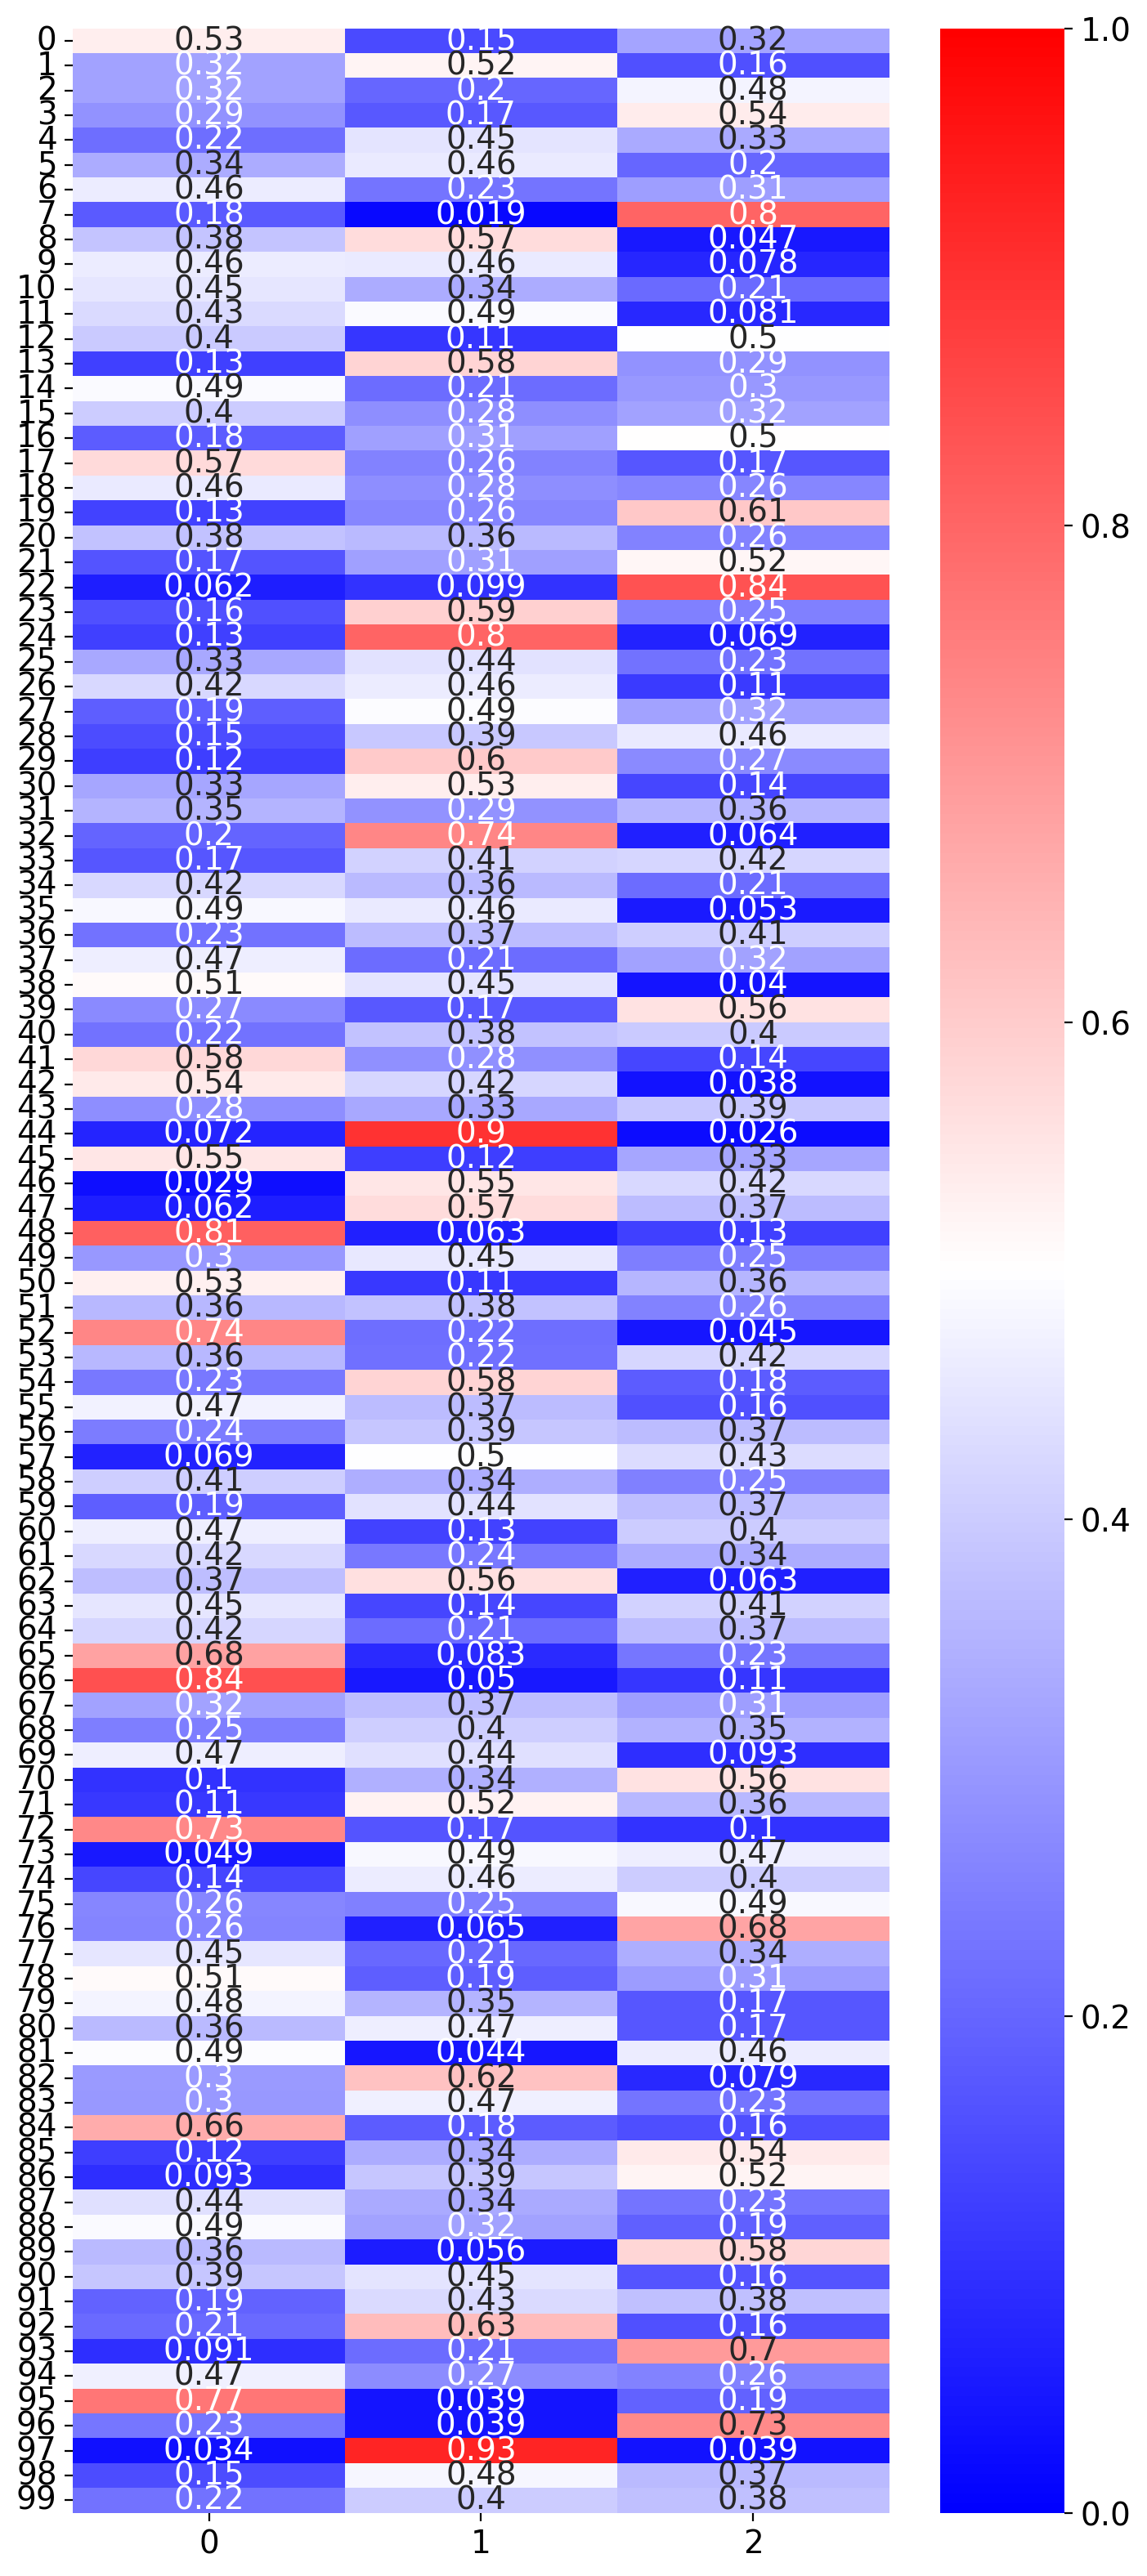

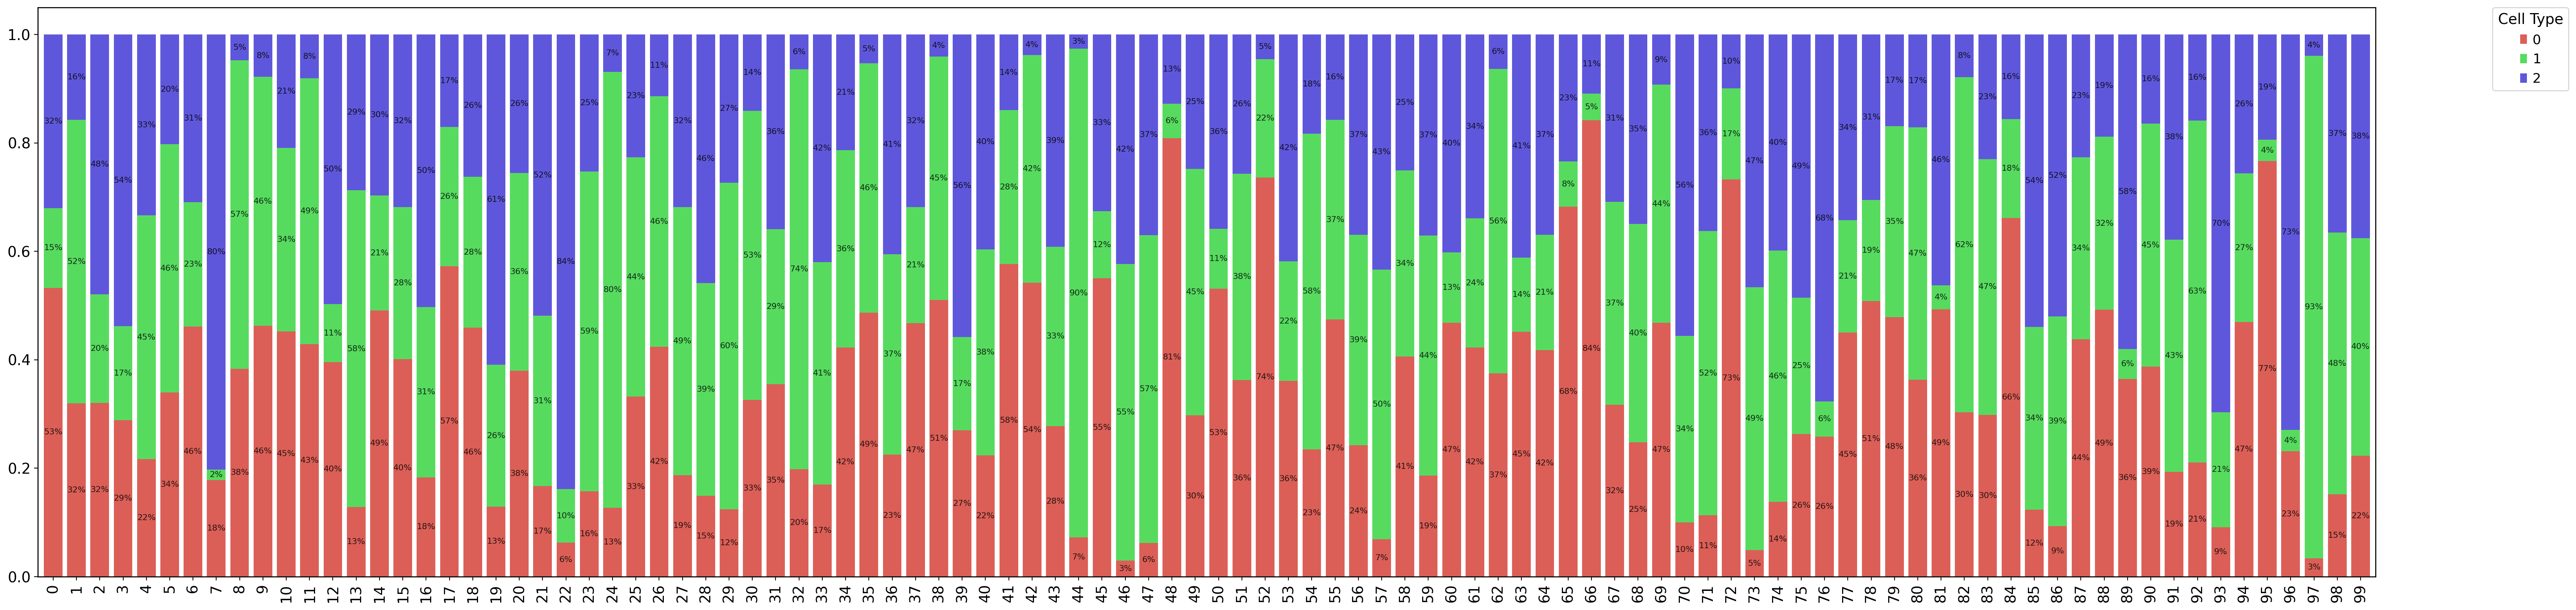

In [21]:
est_df = decon.deconvolute()

In [22]:
true_df = pd.read_csv("../../data/synthetic100/bulk_proportions.csv", index_col=0)
true_df.drop(columns="n_cells", inplace=True)

In [23]:
est_df.reset_index(drop=True, inplace=True)

In [24]:
true_df

,0,1,2
0,0.511972,0.152481,0.335547
1,0.307759,0.523730,0.168511
2,0.305641,0.194240,0.500119
3,0.266643,0.165227,0.568130
4,0.200115,0.453825,0.346060
...,...,...,...
95,0.746312,0.038374,0.215314
96,0.204091,0.036037,0.759872
97,0.017337,0.942209,0.040453
98,0.137069,0.474475,0.388456


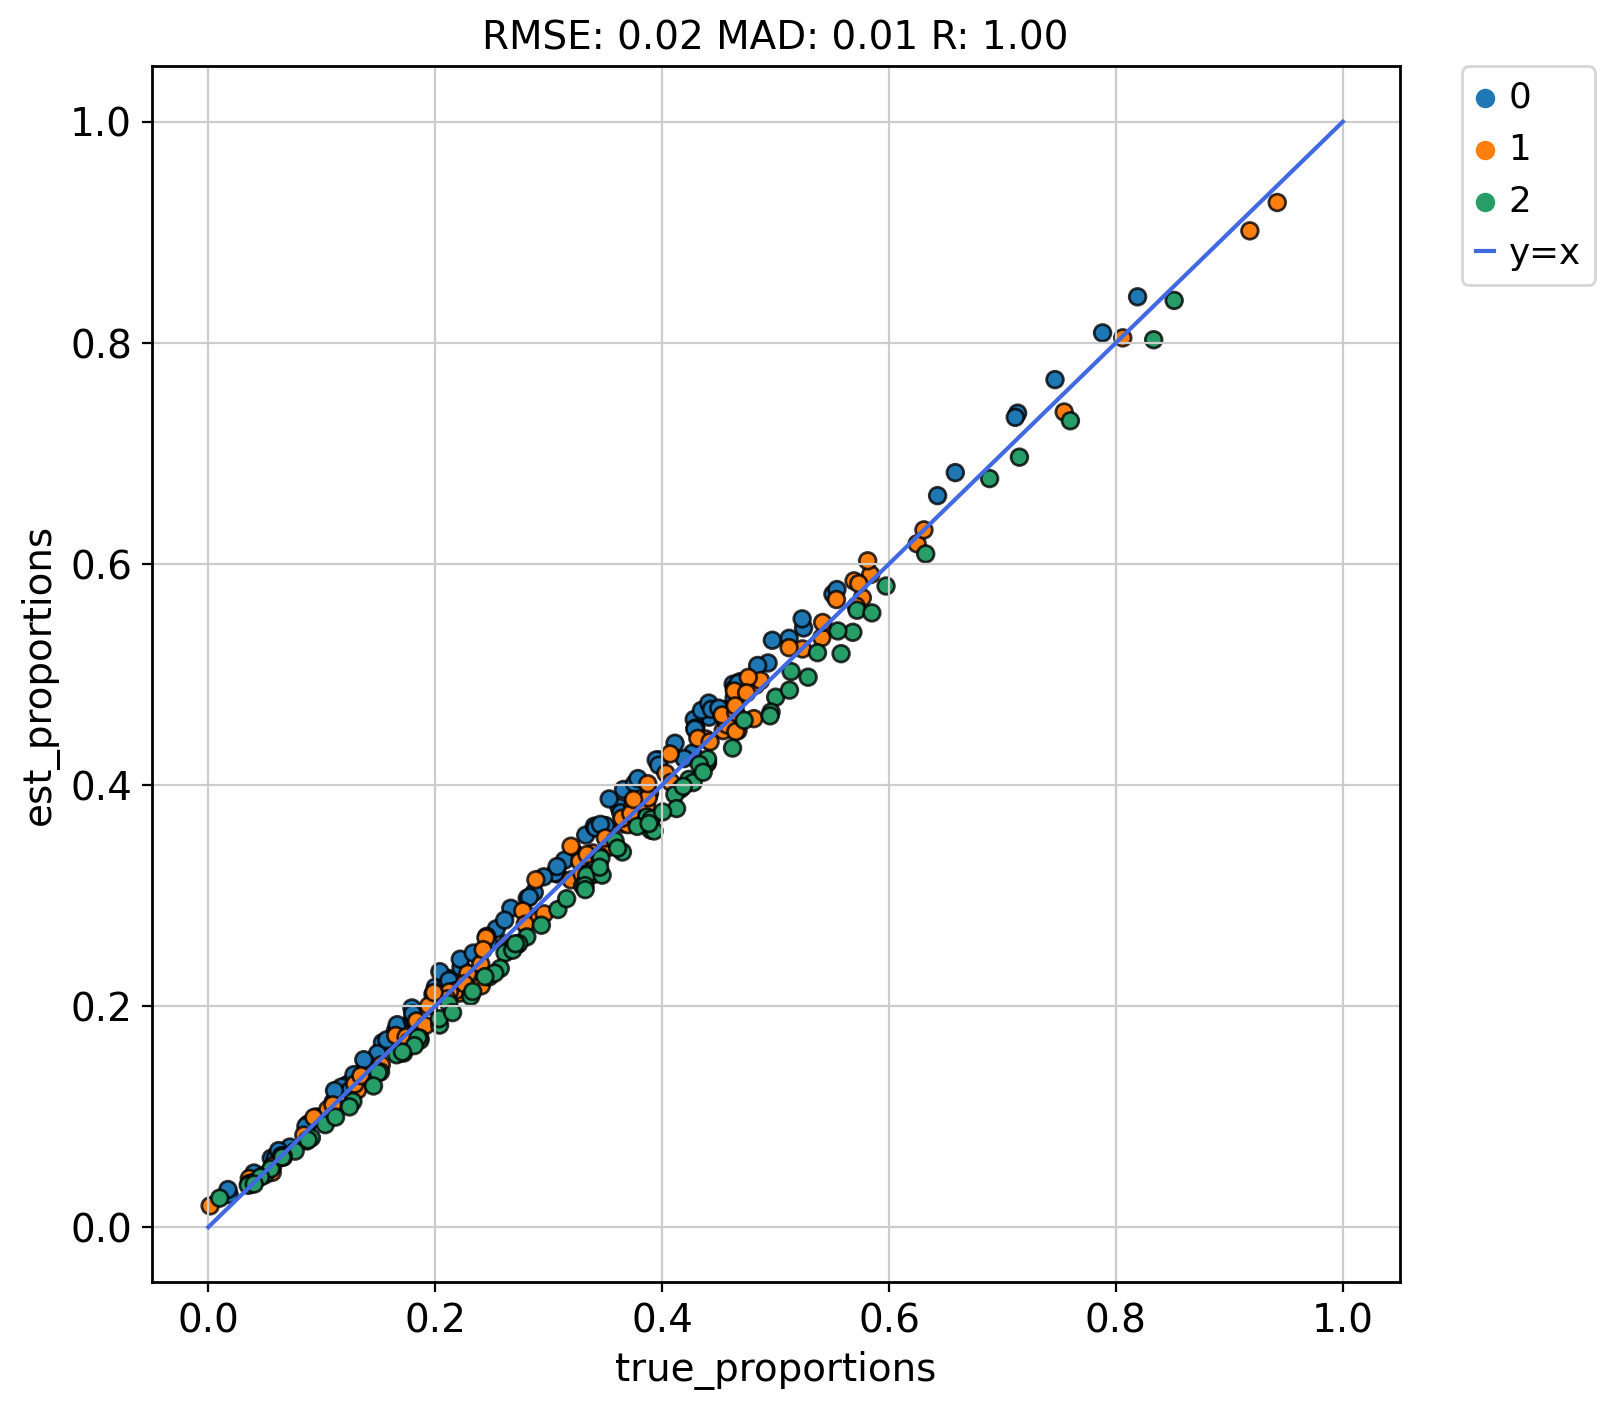

In [25]:
dv.pl.scatter_check(true_df, est_df)

In [26]:
pd.DataFrame({
    "MuSiC": [0.10, 0.06, 0.94],
    "NNLS": [0.17, 0.12, 0.82],
    "BSEQ-sc": [0.21, 0.15, 0.79],
    "CIBERSORT": [0.21, 0.15, 0.76],
    "Normal": [0.16, 0.10, 0.79],
    "Poisson": [0.11, 0.09, 0.91]},
    index=["RMSD", "mAD", "R"]
)

,MuSiC,NNLS,BSEQ-sc,CIBERSORT,Normal,Poisson
RMSD,0.10,0.17,0.21,0.21,0.16,0.11
mAD,0.06,0.12,0.15,0.15,0.10,0.09
R,0.94,0.82,0.79,0.76,0.79,0.91
